In [1]:
import os
os.chdir("..")
assert 'PromptDataExtract' in os.getcwd()

In [2]:
# Load settings
from backend import sett, postgres
sett.load_settings()
postgres.load_settings()

Load OK: settings.yaml


In [3]:
# Connect to database
db = postgres.connect('polylet')

      -- postgres_ SSH tunnel established.
NOTE  -- postgres_ Connected to PostGres DB: polylet (took 0.051 s)


In [4]:
import json
import datetime
import pandas as pd
import matplotlib.pyplot as plt
try:
    plt.style.use("~/matplotlib.mplstyle")
except: pass

In [5]:
def execute(sql, **kwargs) -> pd.DataFrame:
    """ Query the database using raw sql.
        Return a pandas dataframe containing the results.
    """
    results = postgres.raw_sql(sql, kwargs)
    if not results:
        return None
    return pd.DataFrame.from_records(results, columns=results[0]._fields)

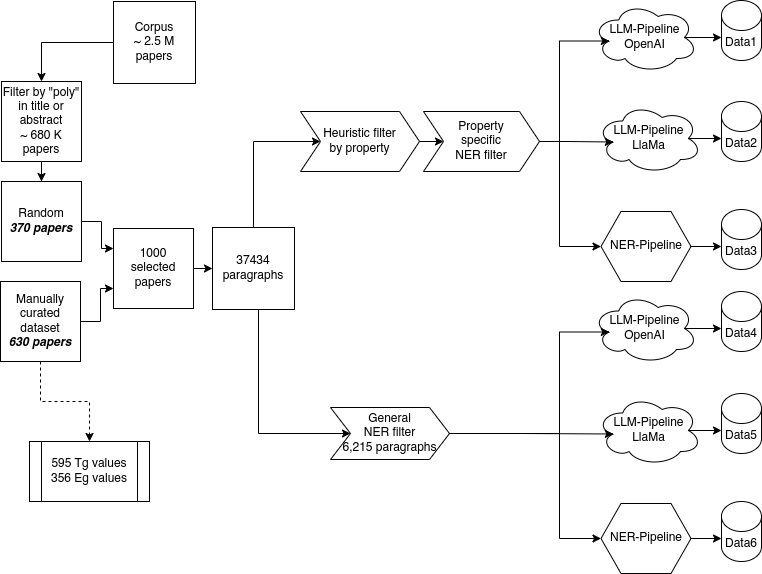

In [19]:
from IPython.display import Image
Image(filename="notebooks/Figure01.png")

In [6]:
# List of extraction methods.
execute("""select * from extraction_methods order by dataset""")

,name,dataset,model,api,para_subset,extraction_info,id,date_added
0,g-ner-gpt-sel1k,data4,gpt-3.5-turbo,openai,select-1k_ner-filter,{'user': 'akhlak'},3,2023-09-26 08:53:00-04:00
1,g-ner-llama-sel1k,data5,llama,polyai,select-1k_ner-filter,{'user': 'akhlak'},4,2023-09-26 08:54:00-04:00
2,g-ner-bert-sel1k,data6,materials-bert,None,select-1k_ner-filter,{'user': 'akhlak'},5,2023-09-26 08:56:00-04:00
3,g-ner-pipeline,data7,materials-bert,None,ner_filter,{'user': 'akhlak'},1,2023-09-25 19:37:00-04:00
4,test,test-data,test-model,None,select-1k_ner-filter,{'comment': 'Method for testing purposes.'},2,2023-09-25 23:20:00-04:00


In [7]:
# Number of selected papers.
execute("""
    SELECT count(*) FROM filtered_papers fp 
    WHERE fp.filter_name = 'select-1k';
""")

,count
0,1000


In [8]:
# Number of the selected papers from the curated dataset.
execute("""
SELECT count(*) FROM filtered_papers fp 
WHERE fp.filter_name = 'select-1k'
AND EXISTS (
	SELECT 1 FROM curated_data cd 
	WHERE cd.doi = fp.doi
);""")

,count
0,630


In [9]:
# Number of paragraphs from the select 1k.
execute("""
    SELECT count(*) FROM paper_texts pt 
    JOIN filtered_papers fp ON fp.doi = pt.doi 
    WHERE fp.filter_name = 'select-1k';
""")

,count
0,37434


## Data6 - General NER - NER Pipeline.

In [10]:
method = postgres.raw_sql("""
    Select * From extraction_methods Where dataset = 'data6';
""")[0]
method

Row(name='g-ner-bert-sel1k', dataset='data6', model='materials-bert', api=None, para_subset='select-1k_ner-filter', extraction_info={'user': 'akhlak'}, id=5, date_added=datetime.datetime(2023, 9, 26, 8, 56, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000))))

In [11]:
# Number of paragraphs that passed the General NER filter.
execute("""
        SELECT count(*) FROM filtered_paragraphs fp 
        WHERE fp.filter_name = :method_para;
        
        """, method_para = method.para_subset)

,count
0,6215


In [12]:
# Number of materials extracted.
execute("""
        SELECT count(*) FROM extracted_materials em
        WHERE em.method_id = :mid;
        
        """, mid=method.id)

,count
0,9106


In [13]:
# Number of properties extracted.
execute("""
        SELECT count(*) FROM extracted_properties ep
        WHERE ep.method_id = :mid;
        
        """, mid=method.id)

,count
0,16368


In [14]:
# F1-score for Tg.
with open("runs/select-1k/bert/tg_metrics.json") as fp:
    print(json.load(fp))

{'method': 'g-ner-bert-sel1k', 'material': {'true_positives': 701, 'false_positives': 77, 'false_negatives': 146, 'precision': 0.9010282776349614, 'recall': 0.8276269185360094, 'F1': 0.8627692307692308}, 'value': {'true_positives': 544, 'false_positives': 234, 'false_negatives': 46, 'precision': 0.699228791773779, 'recall': 0.9220338983050848, 'F1': 0.7953216374269008}, 'property': {'true_positives': 432, 'false_positives': 346, 'false_negatives': 161, 'precision': 0.5552699228791774, 'recall': 0.7284991568296796, 'F1': 0.6301969365426696}}


In [15]:
# F1-score for Bandgap.
with open("runs/select-1k/bert/eg_metrics.json") as fp:
    print(json.load(fp))

{'method': 'g-ner-bert-sel1k', 'material': {'true_positives': 332, 'false_positives': 21, 'false_negatives': 118, 'precision': 0.9405099150141643, 'recall': 0.7377777777777778, 'F1': 0.8268991282689913}, 'value': {'true_positives': 317, 'false_positives': 36, 'false_negatives': 23, 'precision': 0.8980169971671388, 'recall': 0.9323529411764706, 'F1': 0.9148629148629148}, 'property': {'true_positives': 233, 'false_positives': 120, 'false_negatives': 121, 'precision': 0.660056657223796, 'recall': 0.6581920903954802, 'F1': 0.659123055162659}}


In [26]:
# Time for filtering.
!grep "All done." runs/select-1k/filter/*.log

[23-09-26 EDT 08:57:06 AM] NOTE  -- All done. (took 2516.329 s)


In [27]:
# Time for the pipeline.
!grep "All done." runs/select-1k/bert/ner-filtered*.log

runs/select-1k/bert/ner-filtered.01.log:[23-09-27 EDT 02:59:47 PM] NOTE  -- All done. (took 42.097 s)
runs/select-1k/bert/ner-filtered.log:[23-09-27 EDT 03:43:35 PM] NOTE  -- All done. (took 2254.671 s)


In [28]:
# Total time on the pipeline.
str(datetime.timedelta(seconds = 2516 + 42 + 2254))

'1:20:12'

In [17]:
postgres.disconnect()